In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
!pip install schwimmbad

  Created wheel for schwimmbad: filename=schwimmbad-0.3.0-cp36-none-any.whl size=11899 sha256=e8ecbc06efa989f9d6d826b051c8cb9312d2bc86ed40de3de58c61c50e757abb
  Stored in directory: /root/.cache/pip/wheels/02/e1/77/0a5ab88509edf14e2ce4d5677912d86e6284435218165dbcff
Successfully built schwimmbad


In [0]:
!pip install cesium

     |████████████████████████████████| 225kB 6.6MB/s 
     |████████████████████████████████| 563kB 32.3MB/s 
  Created wheel for gatspy: filename=gatspy-0.3-cp36-none-any.whl size=43806 sha256=4291327fc492a653c17548543aac73ee506a1eaf91ca7fa0c3c321375f47d240
  Stored in directory: /root/.cache/pip/wheels/4f/8f/fa/0d7b250ef21828ca373b21f6b3b6ef0f2a0e3560b69c91e55d
Successfully built gatspy


In [0]:
%matplotlib notebook
%matplotlib inline
import sys
import os
from collections import Counter, OrderedDict
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
from astropy.table import Table
import schwimmbad
from cesium.time_series import TimeSeries
import cesium.featurize as featurize
from tqdm import tnrange, tqdm_notebook
import sklearn 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [0]:
pbmap = OrderedDict([(0,'u'), (1,'g'), (2,'r'), (3,'i'), (4, 'z'), (5, 'y')])

# it also helps to have passbands associated with a color
pbcols = OrderedDict([(0,'blueviolet'), (1,'green'), (2,'red'),\
                      (3,'orange'), (4, 'black'), (5, 'brown')])

pbnames = list(pbmap.values())
pbnames

['u', 'g', 'r', 'i', 'z', 'y']

In [0]:
cd /gdrive/My\ Drive

/gdrive/My Drive


In [0]:
pwd

'/gdrive/My Drive'

In [0]:
datadir = 'data/'
metafilename = f'{datadir}/plasticc_train_metadata.csv'
metadata = Table.read(metafilename, format='csv')
nobjects = len(metadata)
metadata

object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
int64,float64,float64,int64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
615,349.0461,-61.9438,1,0.0,0.0,0.0,-9.0,0.017,92,92,1,0.0,0.0,0.0,0.0,0.0,0.0,59570.0,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,88,1,1.817,45.703,0.0,0.0,0.0,0.0,59570.0,34,108.7,117.7,119.9,149.6,147.9,150.5
730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,42,2,0.233,40.328,0.004,4.5,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,90,1,0.301,40.969,-0.004,257.7,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,90,1,0.193,39.866,-0.002,-368.8,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0
1227,35.6836,-5.3794,1,0.0,0.0,0.0,-9.0,0.02,65,65,1,0.0,0.0,0.0,0.0,0.0,0.0,59570.0,47,2.3,11.6,31.6,240.0,632.4,1187.7
1598,347.8467,-64.7609,1,0.135,0.182,0.03,39.728,0.019,90,90,1,0.136,39.03,-0.002,-135.1,0.0,0.0,60628.816,20,0.0,0.0,0.0,0.0,0.0,0.0
1632,348.5959,-63.0726,1,0.686,0.701,0.01,43.152,0.021,42,42,3,0.688,43.097,-0.029,-626.6,3.1,0.051,59602.09,93,0.0,0.0,0.0,0.0,0.0,0.0
1920,149.4141,3.4338,1,0.309,0.323,0.336,41.14,0.027,90,90,1,0.311,41.038,0.002,-290.8,0.0,0.0,59996.625,107,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
max(metadata['hostgal_photoz']), min(metadata['hostgal_photoz'])

(2.999, 0.0)

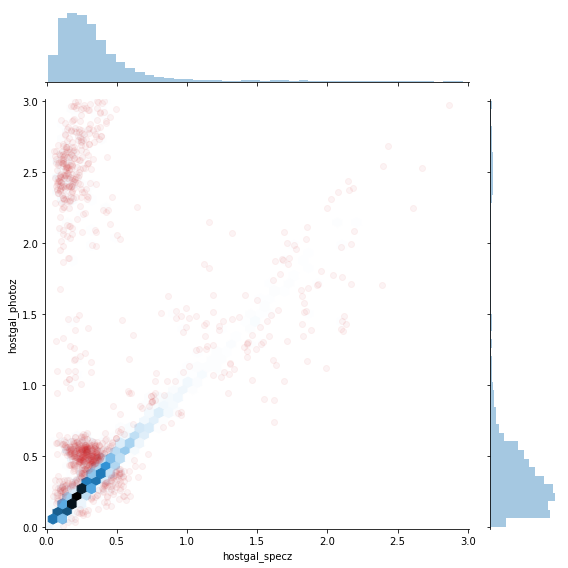

In [0]:
extragal = metadata['hostgal_specz'] != 0.
g = sns.jointplot(metadata['hostgal_specz'][extragal],\
              metadata['hostgal_photoz'][extragal], kind='hex',\
                  xlim=(-0.01, 3.01), ylim=(-0.01,3.01), height=8)

outliers = np.abs(metadata['hostgal_specz'] - metadata['hostgal_photoz']) > 0.1    # accuracy between photoz and specz
fig = g.fig
fig.axes[0].scatter(metadata['hostgal_specz'][outliers],\
                    metadata['hostgal_photoz'][outliers], color='C3', alpha=0.05
                   )
fig.tight_layout()

In [0]:
counts = Counter(metadata['target'])
counts

Counter({6: 151,
         15: 495,
         16: 924,
         42: 1193,
         52: 183,
         53: 30,
         62: 484,
         64: 102,
         65: 981,
         67: 208,
         88: 370,
         90: 2313,
         92: 239,
         95: 175})

In [0]:
labels, values = zip(*sorted(counts.items(), key=itemgetter(1)))
labels, values

((53, 64, 6, 95, 52, 67, 92, 88, 62, 15, 16, 65, 42, 90),
 (30, 102, 151, 175, 183, 208, 239, 370, 484, 495, 924, 981, 1193, 2313))

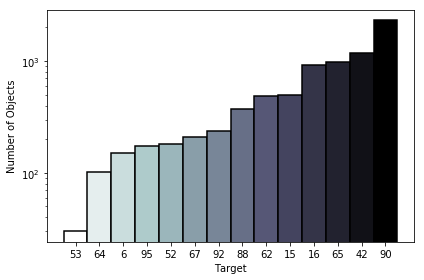

In [0]:
fig, ax = plt.subplots()
cmap = plt.cm.bone

nlines = len(labels)
classcolor =  list(cmap(np.linspace(0,1,nlines)))[::-1]

# we'll create a mapping between class and color
classcolmap = dict(zip(labels, classcolor))

indexes = np.arange(nlines)
width = 1
ax.bar(indexes, values, width, edgecolor='k',\
       linewidth=1.5, tick_label=labels, log=True, color=classcolor)
ax.set_xlabel('Target')
ax.set_ylabel('Number of Objects')
fig.tight_layout()

In [0]:
lcfilename = f'{datadir}/plasticc_train_lightcurves.csv'
lcdata = Table.read(lcfilename, format='csv')
lcdata

object_id,mjd,passband,flux,flux_err,detected_bool
int64,float64,int64,float64,float64,int64
615,59750.4229,2,-544.810303,3.622952,1
615,59750.4306,1,-816.434326,5.55337,1
615,59750.4383,3,-471.385529,3.801213,1
615,59750.445,4,-388.984985,11.395031,1
615,59752.407,2,-681.858887,4.041204,1
615,59752.4147,1,-1061.457031,6.472994,1
615,59752.4224,3,-524.95459,3.552751,1
615,59752.4334,4,-393.480225,3.599346,1
615,59752.4435,5,-355.88678,10.421921,1


In [0]:
tsdict = OrderedDict()
for i in tnrange(nobjects, desc='Building Timeseries'):
    row = metadata[i]
    thisid = row['object_id']
    target = row['target']
    
    meta = {'z':row['hostgal_photoz'],\
            'zerr':row['hostgal_photoz_err'],\
            'mwebv':row['mwebv']}
    
    ind = (lcdata['object_id'] == thisid)
    thislc = lcdata[ind]

    pbind = [(thislc['passband'] == pb) for pb in pbmap]
    t = [thislc['mjd'][mask].data for mask in pbind ]
    m = [thislc['flux'][mask].data for mask in pbind ]
    e = [thislc['flux_err'][mask].data for mask in pbind ]

    tsdict[thisid] = TimeSeries(t=t, m=m, e=e,\
                        label=target, name=thisid, meta_features=meta,\
                        channel_names=pbnames )
    
del lcdata

In [0]:
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]

In [0]:

# we'll turn off warnings for a bit, because numpy can be whiny. 
import warnings
warnings.simplefilter('ignore')

In [0]:
def worker(tsobj):
    global features_to_use
    thisfeats = featurize.featurize_single_ts(tsobj,\
    features_to_use=features_to_use,
    raise_exceptions=False)
    return thisfeats

In [0]:
featurefile = f'{datadir}/plasticc_featuretable.npz'
if os.path.exists(featurefile):
    featuretable, _ = featurize.load_featureset(featurefile)
else:
    features_list = []
    with tqdm_notebook(total=nobjects, desc="Computing Features") as pbar:
        with schwimmbad.MultiPool() as pool:  
            results = pool.imap(worker, list(tsdict.values()))
            for res in results:
                features_list.append(res)
                pbar.update()
            
    featuretable = featurize.assemble_featureset(features_list=features_list,\
                              time_series=tsdict.values())
    featurize.save_featureset(fset=featuretable, path=featurefile)

In [0]:
old_names = featuretable.columns.values
new_names = ['{}_{}'.format(x, pbmap.get(y,'meta')) for x,y in old_names]
cols = [featuretable[col] for col in old_names]
allfeats = Table(cols, names=new_names)
del featuretable

In [0]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
splits = list(splitter.split(allfeats, metadata['target']))[0]
train_ind, test_ind = splits



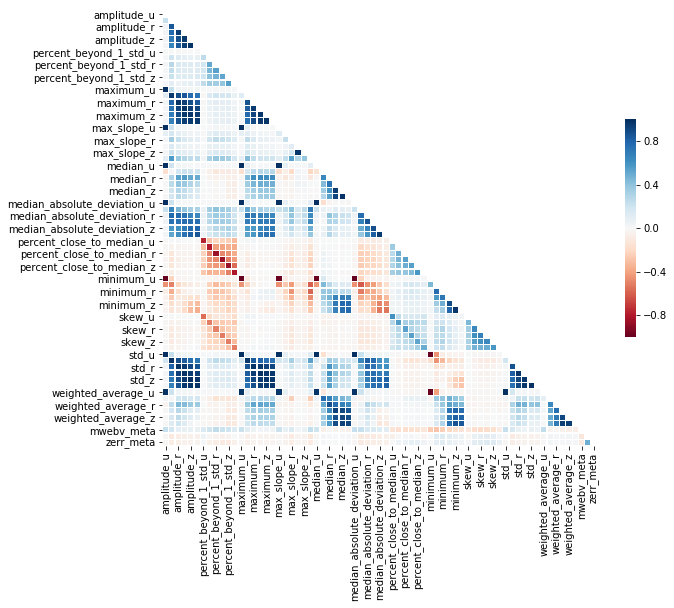

In [0]:
corr = allfeats.to_pandas().corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
corr_plot = sns.heatmap(corr, mask=mask, cmap='RdBu', center=0,
                square=True, linewidths=.2, cbar_kws={"shrink": .5})


In [0]:
Xtrain = np.array(allfeats[train_ind].as_array().tolist())
Ytrain = np.array(metadata['target'][train_ind].tolist())

Xtest  = np.array(allfeats[test_ind].as_array().tolist())
Ytest  = np.array(metadata['target'][test_ind].tolist())

In [0]:
ncols = len(new_names)
npca  = (ncols  - 3)//len(pbnames)  + 3

In [0]:
pca = PCA(n_components=npca, whiten=True, svd_solver="full", random_state=42)
Xtrain_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.transform(Xtest)

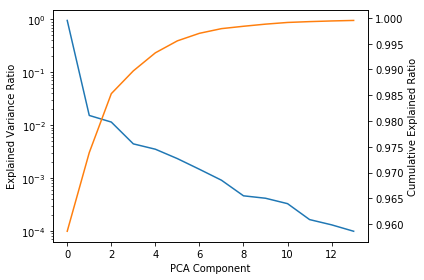

In [0]:
fig, ax = plt.subplots()
ax.plot(np.arange(npca), pca.explained_variance_ratio_, color='C0')
ax2 = ax.twinx()
ax2.plot(np.arange(npca), np.cumsum(pca.explained_variance_ratio_), color='C1')
ax.set_yscale('log')
ax.set_xlabel('PCA Component')
ax.set_ylabel('Explained Variance Ratio')
ax2.set_ylabel('Cumulative Explained Ratio')
fig.tight_layout()

In [0]:
clf = RandomForestClassifier(n_estimators=200, criterion='gini',\
                       oob_score=True, n_jobs=-1, random_state=42,\
                      verbose=1, class_weight='balanced', max_features='sqrt')


In [0]:
clf.fit(Xtrain_pca, Ytrain)
Ypred = clf.predict(Xtest_pca)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished


In [0]:
cm = confusion_matrix(Ytest, Ypred, labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)



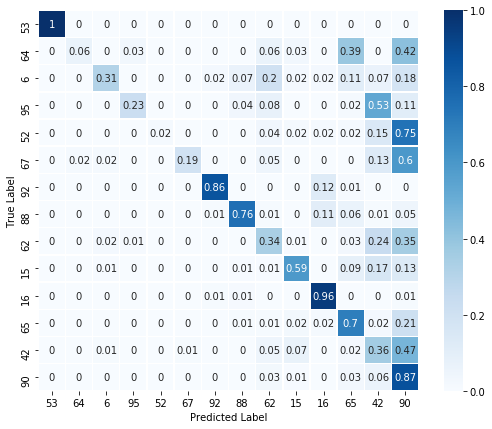

In [0]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

In [0]:
def plasticc_log_loss(y_true, y_pred, relative_class_weights=None):
        """
        Implementation of weighted log loss used for the Kaggle challenge
        """
        predictions = y_pred.copy()

        # sanitize predictions
        epsilon = sys.float_info.epsilon # this is machine dependent but essentially prevents log(0)
        predictions = np.clip(predictions, epsilon, 1.0 - epsilon)
        predictions = predictions / np.sum(predictions, axis=1)[:, np.newaxis]

        predictions = np.log(predictions)
        # multiplying the arrays is equivalent to a truth mask as y_true only contains zeros and ones
        class_logloss = []
        for i in range(predictions.shape[1]):
            # average column wise log loss with truth mask applied
            result = np.average(predictions[:, i][y_true[:, i] == 1])
            class_logloss.append(result)
        return -1 * np.average(class_logloss, weights=relative_class_weights)

In [0]:
# we didn't release the weights with the contest at Kaggle's request
# they have been probed through the leaderboard though
# we leave the reader to adjust this as they see fit
# the official metric is always what is on Kaggle's leaderboard. 
# This notebook is solely for demonstration.
weights = np.ones(nlines)


# we want the actual prediction probabilities
Ypred = clf.predict_proba(Xtest_pca)

# we also need to express the truth table as a matrix
sklearn_truth = np.zeros((len(Ytest), nlines))
label_index_map = dict(zip(clf.classes_, np.arange(nlines)))
for i, x in enumerate(Ytest):
    sklearn_truth[i][label_index_map[Ytest[i]]] = 1
 
      
logloss = plasticc_log_loss(sklearn_truth, Ypred, relative_class_weights=weights)
print("LogLoss: {:.3f}".format(logloss))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished


LogLoss: 2.166
